In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# load the dataset
training_df = pd.read_excel('drought_training_cbrt_transform.xlsx')

training_df.head()

,339,341,342,344,345,346,348,349,351,352,...,2499,2501,2503,2505,2507,2509,2511,2514,2516,Water Potential (Mpa)_cbrt
0,0.1481,0.1818,0.1748,0.1486,0.1045,0.0782,0.0904,0.0830,0.1101,0.1168,...,0.0332,0.0347,0.0323,0.0308,0.0360,0.0346,0.0320,0.0328,0.0344,-0.447529
1,0.1422,0.1360,0.1384,0.1283,0.1103,0.0967,0.1014,0.1040,0.0934,0.0819,...,0.0560,0.0589,0.0560,0.0551,0.0563,0.0554,0.0533,0.0547,0.0528,-0.529240
2,0.0978,0.0920,0.1038,0.0981,0.0793,0.0613,0.0477,0.0520,0.0545,0.0698,...,0.0280,0.0252,0.0269,0.0275,0.0293,0.0311,0.0284,0.0279,0.0294,-0.504287
3,0.1422,0.1360,0.1538,0.1283,0.1241,0.1161,0.1074,0.0876,0.0831,0.0722,...,0.0456,0.0473,0.0484,0.0452,0.0428,0.0450,0.0486,0.0425,0.0479,-0.548242
4,0.1333,0.1280,0.1307,0.0981,0.1034,0.0838,0.0776,0.0767,0.0779,0.0722,...,0.0373,0.0347,0.0323,0.0330,0.0360,0.0369,0.0344,0.0340,0.0405,-0.688325


In [3]:
# ---------------------------------
# Define predictors and target
# ---------------------------------
X = training_df.drop(columns = ['Water Potential (Mpa)_cbrt'])
y = training_df['Water Potential (Mpa)_cbrt']

In [4]:
# Feature scaling
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# <font color = Orange> Multiple Linear Regression - PLSR

In [5]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for n_components to be integers between 1 and the number of features
    n_components = trial.suggest_int('n_components', 1, X_train.shape[1])
    # Set the range for max_iter to be between 100 and 1000
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    # Create the PLSR model with the specified hyperparameters
    model = PLSRegression(n_components=n_components, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_plsr = PLSRegression(n_components=trial.params['n_components'], max_iter=trial.params['max_iter'])

# Fit the model
best_plsr.fit(X_train, y_train)

# Make predictions
y_pred = best_plsr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-25 21:27:43,585] A new study created in memory with name: no-name-93ccd442-1eee-42ee-94d1-48578e2be810
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 40
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-02-25 21:27:44,579] Trial 0 finished with value: 0.18433255588625697 and parameters: {'n_components': 939, 'max_iter': 518}. Best is trial 0 with value: 0.18433255588625697.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 40
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-02-25 21:27:44,632] Trial 1 finished with value: 0.18433255588625785 and parameters: {'n_components': 192, 'max_iter': 624}. Best is trial 0 with value: 0.18433255588625697.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWar

/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 40
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-02-25 21:27:48,236] Trial 23 finished with value: 0.18433255588625694 and parameters: {'n_components': 107, 'max_iter': 382}. Best is trial 10 with value: 0.10451357374431271.
[I 2024-02-25 21:27:48,262] Trial 24 finished with value: 0.21882183896235022 and parameters: {'n_components': 7, 'max_iter': 469}. Best is trial 10 with value: 0.10451357374431271.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 40
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-02-25 21:27:48,376] Trial 25 finished with value: 0.18433255588625785 and parameters: {'n_components': 265, 'max_iter': 328}. Best is trial 10 with value: 0.10451357374431271.
/Users/trangtran/anaconda3/lib/p

/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 40
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-02-25 21:27:51,076] Trial 48 finished with value: 0.18433255588625785 and parameters: {'n_components': 171, 'max_iter': 665}. Best is trial 10 with value: 0.10451357374431271.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 40
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-02-25 21:27:51,209] Trial 49 finished with value: 0.18433255588625685 and parameters: {'n_components': 471, 'max_iter': 447}. Best is trial 10 with value: 0.10451357374431271.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 40
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 20

/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 40
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-02-25 21:27:52,457] Trial 75 finished with value: 0.18433255588625694 and parameters: {'n_components': 107, 'max_iter': 433}. Best is trial 71 with value: 0.08250534418775476.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 40
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-02-25 21:27:52,495] Trial 76 finished with value: 0.1843325558862558 and parameters: {'n_components': 63, 'max_iter': 526}. Best is trial 71 with value: 0.08250534418775476.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 40
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024

Number of finished trials:  100
Best trial:
  Value: 0.08250534418775476
  Params: 
    n_components: 2
    max_iter: 451
Mean Squared Error: 0.08250534418775476
Root Mean Squared Error: 0.2872374352130216
R-Squared value: 0.4128050458579928


In [6]:
# Get the coefficients from the trained PLSRegression model
coefficients = best_plsr.coef_.flatten()

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")

Top 3 Features:
1898: -0.001237889734718841
1894: -0.0012354534003443283
1902: -0.0012250172055964256


# <font color = Blue> Elastic Net

In [7]:
# Tune the hyperparameters using Optuna
def objective(trial):
    
    # Set the range for alpha to be uniform between 0.0 and 1.0, alpha is the regularization parameter
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for l1_ratio to be uniform between 0.0 and 1.0, l1_ratio is the ElasticNet mixing parameter
    l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
    # Set the range for max_iter to be between 100 and 1000, max_iter is the maximum number of iterations
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    # Create the ElasticNet model with the specified hyperparameters
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    # Return mse as the objective value
    return mse

# Create the Optuna study, we maximize the objective function (the score)
# model.score() returns the coefficient of determination R^2 of the prediction 
# i.e. the percentage of the variance in the target variable that is predictable from the feature variables
study = optuna.create_study(direction='minimize', sampler = TPESampler(seed=37))
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial

# Print the value of the final trial and the best parameters
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_elastic_net = ElasticNet(alpha=study.best_params['alpha'], l1_ratio=study.best_params['l1_ratio'], max_iter=study.best_params['max_iter'])

# Fit the model
best_elastic_net.fit(X_train, y_train)

# Make predictions
y_pred = best_elastic_net.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-25 21:27:54,437] A new study created in memory with name: no-name-ae58212a-0cd4-4968-a889-fa38596e014c
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 21:27:54,463] Trial 0 finished with value: 0.17199074459158273 and parameters: {'alpha': 0.9444966028573069, 'l1_ratio': 0.4640981743044076, 'max_iter': 273}. Best is trial 0 with value: 0.17199074459158273.
/var/folders/3h/63

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 21:27:54,729] Trial 10 finished with value: 0.1062058497939765 and parameters: {'alpha': 0.27682391622961355, 'l1_ratio': 0.06343733200190918, 'max_iter': 457}. Best is trial 10 with value: 0.1062058497939765.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:5: FutureWarning: suggest_uniform has been deprecat

[I 2024-02-25 21:27:55,039] Trial 17 finished with value: 0.17199074459158273 and parameters: {'alpha': 0.5911006058363916, 'l1_ratio': 0.2991527460937409, 'max_iter': 556}. Best is trial 10 with value: 0.1062058497939765.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 21:27:55,070] Trial 18 finished with value: 0.10140266523754173 and parameters: {'alpha': 0.21367247238772677, 'l1_ra

[I 2024-02-25 21:27:55,359] Trial 26 finished with value: 0.10336892387378961 and parameters: {'alpha': 0.21594776159517962, 'l1_ratio': 0.11071729807160194, 'max_iter': 331}. Best is trial 18 with value: 0.10140266523754173.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 21:27:55,396] Trial 27 finished with value: 0.12676256965115515 and parameters: {'alpha': 0.5424545324537513, 'l1_

[I 2024-02-25 21:27:55,771] Trial 35 finished with value: 0.10607368561928325 and parameters: {'alpha': 0.22414541712091124, 'l1_ratio': 0.17872757024780578, 'max_iter': 293}. Best is trial 18 with value: 0.10140266523754173.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 21:27:55,801] Trial 36 finished with value: 0.17199074459158273 and parameters: {'alpha': 0.4463113296824297, 'l1_

[I 2024-02-25 21:27:56,368] Trial 45 finished with value: 0.10780727113819265 and parameters: {'alpha': 0.31691943737637523, 'l1_ratio': 0.13101550851326688, 'max_iter': 646}. Best is trial 18 with value: 0.10140266523754173.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 21:27:56,409] Trial 46 finished with value: 0.10133083611498775 and parameters: {'alpha': 0.6397497457800048, 'l1_

[I 2024-02-25 21:27:56,762] Trial 54 finished with value: 0.13317079465207202 and parameters: {'alpha': 0.5334361923913805, 'l1_ratio': 0.15710381239130625, 'max_iter': 431}. Best is trial 51 with value: 0.10130748887028967.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 21:27:56,835] Trial 55 finished with value: 0.10123017941605644 and parameters: {'alpha': 0.6512131474299095, 'l1_r

[I 2024-02-25 21:27:57,177] Trial 63 finished with value: 0.1423458957537454 and parameters: {'alpha': 0.6822547275494892, 'l1_ratio': 0.1462542633522838, 'max_iter': 374}. Best is trial 55 with value: 0.10123017941605644.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 21:27:57,224] Trial 64 finished with value: 0.10267969104043444 and parameters: {'alpha': 0.5098381270353337, 'l1_rat

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 21:27:57,620] Trial 73 finished with value: 0.10939953642735184 and parameters: {'alpha': 0.6008682543364757, 'l1_ratio': 0.07055076755067938, 'max_iter': 260}. Best is trial 55 with value: 0.10123017941605644.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:7: FutureWarning: suggest_uniform has been depreca

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-25 21:27:57,981] Trial 82 finished with value: 0.1227741451545799 and parameters: {'alpha': 0.5308807477100437, 'l1_ratio': 0.12390099492749103, 'max_iter': 358}. Best is trial 55 with value: 0.10123017941605644.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:7: FutureWarning: suggest_uniform has been deprecat

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.993e-03, tolerance: 4.049e-04
  model = cd_fast.enet_coordinat

Number of finished trials:  100
Best trial:
  Value: 0.10109776551946888
  Params: 
    alpha: 0.6604494760196793
    l1_ratio: 0.019127105099415436
    max_iter: 146
Mean Squared Error: 0.10109776551946888
Root Mean Squared Error: 0.3179587481411211
R-Squared value: 0.2804817873013056


In [8]:
# Get the coefficients from the trained ElasticNet model
coefficients = best_elastic_net.coef_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")


Top 3 Features:
357: -0.023767350169863928
386: -0.019587316612406827
351: 0.016727344766274067


# <font color = Red> Non-linear Kernel Ridge Regression (KRR)

In [9]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for alpha to be uniform between 0.0 and 1.0
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for gamma to be loguniform between 1e-6 and 1e6
    gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
    # Set the range for kernel to be categorical between 'linear' and 'rbf'
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    
    # Create the Kernel Ridge Regression model with the specified hyperparameters
    model = KernelRidge(alpha=alpha, gamma=gamma, kernel=kernel)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_krr = KernelRidge(alpha=trial.params['alpha'], gamma=trial.params['gamma'], kernel=trial.params['kernel'])

# Fit the model
best_krr.fit(X_train, y_train)

# Make predictions
y_pred = best_krr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-25 21:27:58,917] A new study created in memory with name: no-name-3f82c653-9c53-44a4-a046-0dd7cae39c04
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 21:27:58,944] Trial 0 finished with value: 1.3324893712052819 and parameters: {'alpha': 0.9444966028573069, 'gamma': 0.3708327584362581, 'kernel': 'rbf'}. Best is trial 0 with value: 1.3324893712052819.
/var/fold

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 21:27:59,091] Trial 10 finished with value: 0.10330187654458167 and parameters: {'alpha': 0.003915949640957761, 'gamma': 8.218006795527931e-06, 'kernel': 'rbf'}. Best is trial 10 with value: 0.10330187654458167.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:4: FutureWarning: suggest_uniform ha

[I 2024-02-25 21:27:59,340] Trial 19 finished with value: 1.1590471711896428 and parameters: {'alpha': 0.26815016060719377, 'gamma': 0.021529909135048243, 'kernel': 'rbf'}. Best is trial 11 with value: 0.1020874850552736.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 21:27:59,373] Trial 20 finished with value: 0.15795333349622295 and parameters: {'alpha': 0.089437461288

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 21:27:59,652] Trial 30 finished with value: 1.3314792755376321 and parameters: {'alpha': 0.3928432009924365, 'gamma': 0.08039597906584256, 'kernel': 'rbf'}. Best is trial 11 with value: 0.1020874850552736.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:4: FutureWarning: suggest_uniform has been

[I 2024-02-25 21:27:59,856] Trial 39 finished with value: 1.3324893712054278 and parameters: {'alpha': 0.05588118814102934, 'gamma': 16.4293947043477, 'kernel': 'rbf'}. Best is trial 11 with value: 0.1020874850552736.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 21:27:59,880] Trial 40 finished with value: 0.16260821884438215 and parameters: {'alpha': 0.1697507216980435

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 21:28:00,087] Trial 49 finished with value: 0.10802354611022524 and parameters: {'alpha': 0.0047622526533067575, 'gamma': 1.0028689732618852e-06, 'kernel': 'rbf'}. Best is trial 11 with value: 0.1020874850552736.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:6: FutureWarning: suggest_logunifor

[I 2024-02-25 21:28:00,308] Trial 58 finished with value: 0.12968257197661412 and parameters: {'alpha': 0.026892994164779072, 'gamma': 0.0002547089664186771, 'kernel': 'rbf'}. Best is trial 11 with value: 0.1020874850552736.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 21:28:00,330] Trial 59 finished with value: 1.3324893712054278 and parameters: {'alpha': 0.0755166694

[I 2024-02-25 21:28:00,548] Trial 68 finished with value: 0.11152656306239685 and parameters: {'alpha': 0.02651417529747189, 'gamma': 4.912797676661995e-05, 'kernel': 'rbf'}. Best is trial 11 with value: 0.1020874850552736.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 21:28:00,572] Trial 69 finished with value: 16.517945553748795 and parameters: {'alpha': 0.27575894569

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 21:28:00,793] Trial 78 finished with value: 0.1091164070492776 and parameters: {'alpha': 0.03304243715574382, 'gamma': 7.573999636941245e-06, 'kernel': 'rbf'}. Best is trial 11 with value: 0.1020874850552736.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:6: FutureWarning: suggest_loguniform ha

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 21:28:01,053] Trial 88 finished with value: 0.19423053746005056 and parameters: {'alpha': 0.002373242603728147, 'gamma': 0.0001593315476534724, 'kernel': 'rbf'}. Best is trial 11 with value: 0.1020874850552736.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:4: FutureWarning: suggest_uniform has

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-25 21:28:01,285] Trial 97 finished with value: 0.1284409182945976 and parameters: {'alpha': 0.02708811047605005, 'gamma': 1.8579920312604966e-06, 'kernel': 'rbf'}. Best is trial 11 with value: 0.1020874850552736.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/295769073.py:6: FutureWarning: suggest_loguniform h

Number of finished trials:  100
Best trial:
  Value: 0.1020874850552736
  Params: 
    alpha: 0.00602821288088673
    gamma: 2.1822704835783435e-06
    kernel: rbf
Mean Squared Error: 0.1020874850552736
Root Mean Squared Error: 0.3195113222646008
R-Squared value: 0.27343790034874904


In [10]:
# Get the dual coefficients from the trained KernelRidge model
coefficients = best_krr.dual_coef_

# Calculate the squared magnitude of coefficients (as they are signed)
squared_magnitude = np.abs(coefficients) ** 2

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, squared_magnitude))

# Sort the features by their squared magnitude (importance)
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, magnitude in sorted_features[:top_n]:
    print(f"{feature}: {magnitude}")


Top 3 Features:
396: 8442.805087612567
344: 7989.939067690955
351: 7923.312735660994


# Principal Component Regression (PCR)

Number of components that explain at least 95% of the variance: 3


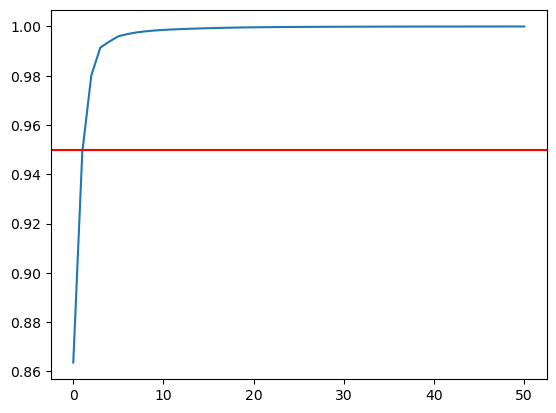

In [11]:
# Create an instance of PCA
pca = PCA(random_state= 37)

# Perform PCA on the predictors DataFrame
pca.fit(X)

# Calculate the cumulative sum of the explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance with a vertical line at 95%
plt.plot(cumulative_explained_variance)
plt.axhline(y=0.95, color='r', linestyle='-')

# Find the number of components that explain at least 95% of the variance
pca_n_components = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1

print(f'Number of components that explain at least 95% of the variance: {pca_n_components}')

In [12]:
# Define the number of principal components to retain
n_components = pca_n_components

# Create a pipeline with PCA and Linear Regression
pipeline = make_pipeline(PCA(n_components), LinearRegression())

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

Mean Squared Error: 0.08588213875251348
Root Mean Squared Error: 0.2930565453159398
R-Squared value: 0.38877221805609674


In [13]:
# Get the principal components from the trained PCA model within the pipeline
principal_components = pipeline.named_steps['pca'].components_

# Calculate the squared loadings of each feature on the principal components
squared_loadings = principal_components ** 2

# Sum the squared loadings across principal components to get feature importance
feature_importance = squared_loadings.sum(axis=0)

# Get the names of the original features
feature_names = X.columns

# Create a dictionary to store feature importance with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
516: 0.007582500860643133
514: 0.007567127839993877
517: 0.007528902309532997


# <font color = Purple> Ensemble Methods

## <font color = darkgreen> Random Forest Regression

In [14]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create the Random Forest model with the specified hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Random Forest model using the best parameters
best_rf_model = RandomForestRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    min_samples_split=trial.params['min_samples_split'], 
    min_samples_leaf=trial.params['min_samples_leaf']
)

# Fit the model
best_rf_model.fit(X_train, y_train)

# Make predictions
y_pred = best_rf_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-25 21:28:01,726] A new study created in memory with name: no-name-ae60e608-b2d0-4295-a840-c20a4d62f57d
[I 2024-02-25 21:28:02,642] Trial 0 finished with value: 0.15113794809562583 and parameters: {'n_estimators': 145, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.15113794809562583.
[I 2024-02-25 21:28:03,137] Trial 1 finished with value: 0.1503264643491866 and parameters: {'n_estimators': 112, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.1503264643491866.
[I 2024-02-25 21:28:03,540] Trial 2 finished with value: 0.15457499356182175 and parameters: {'n_estimators': 78, 'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.1503264643491866.
[I 2024-02-25 21:28:04,233] Trial 3 finished with value: 0.1323834592300808 and parameters: {'n_estimators': 94, 'max_depth': 30, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 3 with va

[I 2024-02-25 21:28:38,058] Trial 36 finished with value: 0.12964247671713192 and parameters: {'n_estimators': 126, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 32 with value: 0.12121690469844625.
[I 2024-02-25 21:28:40,019] Trial 37 finished with value: 0.13111601852478308 and parameters: {'n_estimators': 139, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 32 with value: 0.12121690469844625.
[I 2024-02-25 21:28:40,688] Trial 38 finished with value: 0.14946907987251723 and parameters: {'n_estimators': 118, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 32 with value: 0.12121690469844625.
[I 2024-02-25 21:28:41,343] Trial 39 finished with value: 0.1546045769688775 and parameters: {'n_estimators': 143, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 32 with value: 0.12121690469844625.
[I 2024-02-25 21:28:43,022] Trial 40 finished with value: 0.13247753727642594

[I 2024-02-25 21:29:33,687] Trial 72 finished with value: 0.11953989044829393 and parameters: {'n_estimators': 129, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 52 with value: 0.11732009017920424.
[I 2024-02-25 21:29:35,247] Trial 73 finished with value: 0.1388325747521108 and parameters: {'n_estimators': 128, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 52 with value: 0.11732009017920424.
[I 2024-02-25 21:29:37,734] Trial 74 finished with value: 0.1461666263438405 and parameters: {'n_estimators': 135, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 52 with value: 0.11732009017920424.
[I 2024-02-25 21:29:38,608] Trial 75 finished with value: 0.14847366832414524 and parameters: {'n_estimators': 131, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 52 with value: 0.11732009017920424.
[I 2024-02-25 21:29:40,767] Trial 76 finished with value: 0.13174896113197038 and

Best trial:
  Value: 0.11732009017920424
  Params: 
    n_estimators: 126
    max_depth: 11
    min_samples_split: 6
    min_samples_leaf: 1
Mean Squared Error: 0.12651270642466064
Root Mean Squared Error: 0.3556862471682882
R-Squared value: 0.09960229147876931


## <font color = darkblue> Variable Importance Information of RF

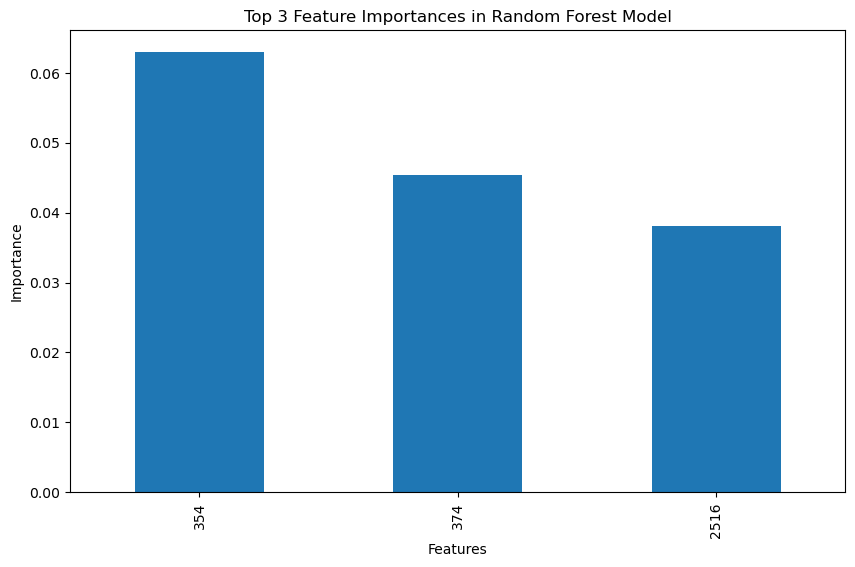

In [15]:
# Extract feature importances
feature_importances = best_rf_model.feature_importances_

# Create a series with feature names and their importance
features = pd.Series(feature_importances, index = X.columns)

# Sort the features by importance
features = features.sort_values(ascending=False)

# Select the top 3 features
top_3_features = features[:3]

# Plot the top 3 feature importances
plt.figure(figsize=(10, 6))
top_3_features.plot(kind='bar')
plt.title('Top 3 Feature Importances in Random Forest Model')
plt.ylabel('Importance')
plt.xlabel('Features')

plt.show()

## <font color = darkgreen> Gradient Boosting Regression

In [16]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)  # Adjust the range for max_depth
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
    
    # Create the Gradient Boosting model with the specified hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate  # Pass learning_rate to the model
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Gradient Boosting model using the best parameters
best_gb_model = GradientBoostingRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate']  # Pass learning_rate to the model
)

# Fit the model
best_gb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_gb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))


[I 2024-02-25 21:30:17,985] A new study created in memory with name: no-name-e1c30501-689e-40f0-8636-88b40b6da981
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:30:21,714] Trial 0 finished with value: 0.1603284496864923 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.027351552606144185}. Best is trial 0 with value: 0.1603284496864923.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.sugg

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:30:53,341] Trial 14 finished with value: 0.09991729090433639 and parameters: {'n_estimators': 53, 'max_depth': 5, 'learning_rate': 0.07849341548804481}. Best is trial 13 with value: 0.09216012231354095.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:30:54,536] Trial 15

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:31:18,792] Trial 28 finished with value: 0.2163701197016672 and parameters: {'n_estimators': 74, 'max_depth': 8, 'learning_rate': 0.07252381030284599}. Best is trial 13 with value: 0.09216012231354095.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:31:22,596] Trial 29 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:31:53,051] Trial 42 finished with value: 0.10853215403704217 and parameters: {'n_estimators': 57, 'max_depth': 5, 'learning_rate': 0.05498706899005896}. Best is trial 35 with value: 0.07988763004531589.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:31:54,886] Trial 43

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:32:23,096] Trial 56 finished with value: 0.1600633710023557 and parameters: {'n_estimators': 93, 'max_depth': 6, 'learning_rate': 0.021821991710477724}. Best is trial 35 with value: 0.07988763004531589.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:32:24,688] Trial 57

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:32:52,711] Trial 70 finished with value: 0.11782107141091264 and parameters: {'n_estimators': 74, 'max_depth': 4, 'learning_rate': 0.040822105356390935}. Best is trial 35 with value: 0.07988763004531589.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:32:54,887] Trial 7

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:33:28,098] Trial 84 finished with value: 0.08789507779931262 and parameters: {'n_estimators': 84, 'max_depth': 5, 'learning_rate': 0.029622740720557896}. Best is trial 35 with value: 0.07988763004531589.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:33:30,076] Trial 8

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:33:54,569] Trial 98 finished with value: 0.11193865363092322 and parameters: {'n_estimators': 73, 'max_depth': 4, 'learning_rate': 0.049535847458333504}. Best is trial 35 with value: 0.07988763004531589.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-25 21:33:59,006] Trial 9

Best trial:
  Value: 0.07988763004531589
  Params: 
    n_estimators: 84
    max_depth: 5
    learning_rate: 0.03400676782551468
Mean Squared Error: 0.08945054216376747
Root Mean Squared Error: 0.299082834953408
R-Squared value: 0.3633756998297968


In [17]:
# Get feature importances from the trained GradientBoostingRegressor model
feature_importances = best_gb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")


Top 3 Features:
374: 0.18869637461921607
2516: 0.06595260515411602
355: 0.05423848286540117


## <font color = green> XGBoost

In [19]:
### Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    
    # Create the XGBoost model with the specified hyperparameters
    model = XGBRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the XGBoost model using the best parameters
best_xgb_model = XGBRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate'],
    min_child_weight=trial.params['min_child_weight'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree']
)

# Fit the model
best_xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-25 22:20:25,398] A new study created in memory with name: no-name-71b58553-8fa9-4262-bae4-a1e44b367f9d
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[I 2024-02-25 22:20:28,394] Trial 6 finished with value: 0.16386842690999118 and parameters: {'n_estimators': 114, 'max_depth': 3, 'learning_rate': 0.08254345345232203, 'min_child_weight': 5, 'subsample': 0.5018019421849012, 'colsample_bytree': 0.7326167078381765}. Best is trial 2 with value: 0.1003774934494484.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-25 22:20:35,651] Trial 19 finished with value: 0.11498343178380005 and parameters: {'n_estimators': 99, 'max_depth': 9, 'learning_rate': 0.07338942984435912, 'min_child_weight': 4, 'subsample': 0.7069183441865234, 'colsample_bytree': 0.7772144339215246}. Best is trial 11 with value: 0.09386909697891506.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-25 22:20:43,458] Trial 32 finished with value: 0.10558688977682143 and parameters: {'n_estimators': 71, 'max_depth': 8, 'learning_rate': 0.09330164372574244, 'min_child_weight': 1, 'subsample': 0.9625055045650783, 'colsample_bytree': 0.7067533863696214}. Best is trial 27 with value: 0.0815089809027144.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-25 22:20:50,158] Trial 45 finished with value: 0.10042542570117105 and parameters: {'n_estimators': 119, 'max_depth': 6, 'learning_rate': 0.08083383853875255, 'min_child_weight': 2, 'subsample': 0.8650033177337746, 'colsample_bytree': 0.6597537007611913}. Best is trial 27 with value: 0.0815089809027144.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-25 22:20:59,607] Trial 58 finished with value: 0.11097162193765384 and parameters: {'n_estimators': 86, 'max_depth': 9, 'learning_rate': 0.09994320809877812, 'min_child_weight': 5, 'subsample': 0.6423804492471383, 'colsample_bytree': 0.637778414245191}. Best is trial 27 with value: 0.0815089809027144.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-25 22:21:06,379] Trial 71 finished with value: 0.08614410853226705 and parameters: {'n_estimators': 93, 'max_depth': 8, 'learning_rate': 0.09756667059777759, 'min_child_weight': 3, 'subsample': 0.679922564306509, 'colsample_bytree': 0.6426778263467462}. Best is trial 27 with value: 0.0815089809027144.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-25 22:21:13,209] Trial 84 finished with value: 0.1233644264961482 and parameters: {'n_estimators': 88, 'max_depth': 7, 'learning_rate': 0.08462388379526373, 'min_child_weight': 4, 'subsample': 0.9553814965309656, 'colsample_bytree': 0.638234309191298}. Best is trial 27 with value: 0.0815089809027144.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9g

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-25 22:21:21,933] Trial 97 finished with value: 0.08572773628314606 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.02210601765231763, 'min_child_weight': 2, 'subsample': 0.9702080557075634, 'colsample_bytree': 0.948217697205467}. Best is trial 27 with value: 0.0815089809027144.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_45180/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y

Best trial:
  Value: 0.0815089809027144
  Params: 
    n_estimators: 76
    max_depth: 7
    learning_rate: 0.09234430904810983
    min_child_weight: 2
    subsample: 0.9833734547461471
    colsample_bytree: 0.875021563221886
Mean Squared Error: 0.0815089809027144
Root Mean Squared Error: 0.28549777740415844
R-Squared value: 0.4198962167297444


In [20]:
# Get feature importances from the trained XGBoost model
feature_importances = best_xgb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
1898: 0.1087125912308693
1902: 0.0880180299282074
364: 0.08294365555047989
